In this notebook, we try to reproduce the results from <i>Table 2<i> in <em>uan, Longhao & Zhao, Qibin. (2017). Completion of High Order Tensor Data with Missing Entries via Tensor-train Decomposition.</em>

In [0]:
# Run if using google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import sys

# From jupyter notebook, starting from Tensor-Completion/
'''
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
'''

# From google colab
# Add parent packages to path
repository_path = "/content/drive/My Drive/Tensor-Completion"
sys.path.append(repository_path)
sys.path.append(repository_path +"/Code")

# Add lib directory, containing the required libraries, to path
libs_path = "/content/drive/My Drive/lib"
sys.path.append(libs_path)

In [0]:
try:
  import cupy as cp
except:
  print("cupy not available")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

from Models.CP_WOPT import CP_WOPT_Model
from Models.TT_WOPT import TT_WOPT_Model
from metrics import RSE, PSNR
from Utils import mask_img, img_to_9D, img_9D_to_3D

img shape:  (256, 256, 3)


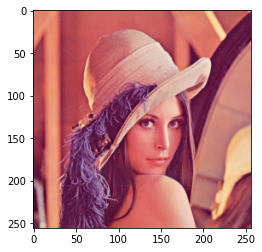

In [0]:
# Read lena image
img_path = '/content/drive/My Drive/Tensor-Completion/Code/data/lena_red.bmp'

img = cv2.imread(img_path, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255
plt.imshow(img)
print("img shape: ", img.shape)

img = cp.asarray(img) # If using cupy

<h2>CP-WOPT</h2>

In [0]:
def run_CP_experiment(img, missing_rates, ranks=[10], n_epochs=10000, gtol=1e-6):
  best_ranks = {}
  rses = {}
  psnrs = {}
  predictions = {}

  for missing_rate in missing_rates:
    best_rse = float("inf")
    best_psnr = 0

    for rank in ranks:
      start = time.time()
      # Mask the tensor
      img_masked = mask_img(img, missing_rate)

      # Train the model
      model = CP_WOPT_Model(img_masked, rank, init="normal", optimization="ncg")
      model.train(n_epochs, gtol)

      # Compute the RSE of our prediction
      prediction = model.predict()
      prediction = prediction.clip(0, 1)
      rse = RSE(img, prediction)
      psnr = PSNR(img*255, prediction*255)
      end = time.time()

      print("mr:", missing_rate)
      print("rank:", rank)
      print("rse:", rse)
      print("psnr:", psnr)
      print("time:", end-start)

      if rse < best_rse and psnr > best_psnr:
        best_ranks[f"mr_{missing_rate}"] = rank
        rses[f"mr_{missing_rate}"] = rse
        psnrs[f"mr_{missing_rate}"] = psnr
        predictions[f"mr_{missing_rate}"] = prediction

        best_rse = rse
        best_psnr = psnr

  return predictions, rses, psnrs, best_ranks

In [0]:
# Run CP experiments
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
ranks = range(4, 11, 2)
predictions, rses, psnrs, best_ranks = run_CP_experiment(img, missing_rates, ranks=ranks)

Optimization terminated successfully.
         Current function value: 0.005737
         Iterations: 3835
         Function evaluations: 7660
         Gradient evaluations: 7660
mr: 0.85
rank: 4
rse: 0.2201048680988344
psnr: 18.268001343833934
time: 20.168662548065186
Optimization terminated successfully.
         Current function value: 0.003616
         Iterations: 6287
         Function evaluations: 13244
         Gradient evaluations: 13244
mr: 0.85
rank: 6
rse: 0.19947348809873194
psnr: 19.122890663602647
time: 35.391587257385254
Optimization terminated successfully.
         Current function value: 0.002779
         Iterations: 10697
         Function evaluations: 19007
         Gradient evaluations: 19007
mr: 0.85
rank: 8
rse: 0.22096445889568156
psnr: 18.23414580325993
time: 51.797768115997314
Optimization terminated successfully.
         Current function value: 0.001929
         Iterations: 16046
         Function evaluations: 28206
         Gradient evaluations: 28206
mr: 0.

In [0]:
best_ranks

{'mr_0.85': 6, 'mr_0.9': 4, 'mr_0.95': 4, 'mr_0.98': 10, 'mr_0.99': 10}

In [0]:
rses

{'mr_0.85': 0.19947348809873194,
 'mr_0.9': 0.2642157115228268,
 'mr_0.95': 0.5023044353390537,
 'mr_0.98': 0.8709357927398791,
 'mr_0.99': 0.8309742195065118}

In [0]:
psnrs

{'mr_0.85': 19.122890663602647,
 'mr_0.9': 16.681421519167966,
 'mr_0.95': 11.10125404462637,
 'mr_0.98': 6.320871523116556,
 'mr_0.99': 6.728843299232922}

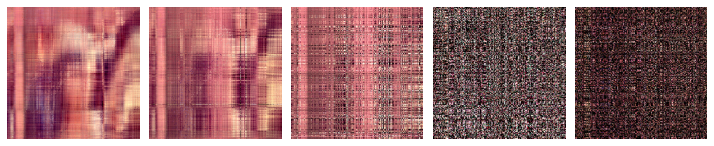

In [0]:
fig = plt.figure(figsize=(10, 10))

n_img = len(missing_rates)

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(cp.asnumpy(prediction))

fig.tight_layout(pad=1.0)

<h2>TT-WOPT</h2>

<h3>3D</h3>

In [0]:
def run_TT_experiment(img, missing_rates, ranks=[16], n_epochs=10000, tensorize_img=False, gtol=1e-6):
  best_ranks = {}
  rses = {}
  psnrs = {}
  predictions = {}

  for missing_rate in missing_rates:
    best_rse = float("inf")
    best_psnr = 0

    for rank in ranks:
      start = time.time()
      if tensorize_img:
        tt_ranks = tuple([1] + [rank] * 8 + [1])
      else:
        tt_ranks = tuple([1] + [rank] * 2 + [1])

      # Mask the tensor and tensorize to 9D
      img_masked = mask_img(img, missing_rate)
      if tensorize_img:
        img_masked = img_to_9D(img_masked)

      # Train the model
      model = TT_WOPT_Model(img_masked, tt_ranks, optimization="ncg")
      model.train(n_epochs, gtol)

      # Compute the prediction and cast back to 3D
      prediction = model.predict()
      prediction = prediction.clip(0, 1)
      if tensorize_img:
        prediction = img_9D_to_3D(prediction, (256, 256, 3))

      # Compute the RSE and PSNR of our prediction
      rse = RSE(img, prediction)
      psnr = PSNR(img*255, prediction*255)

      print("mr:", missing_rate)
      print("rank:", rank)
      print("rse:", rse)
      print("psnr:", psnr)

      if rse < best_rse and psnr > best_psnr:
        best_ranks[f"mr_{missing_rate}"] = rank
        rses[f"mr_{missing_rate}"] = rse
        psnrs[f"mr_{missing_rate}"] = psnr
        predictions[f"mr_{missing_rate}"] = prediction

        best_rse = rse
        best_psnr = psnr

      end = time.time()
      print("time:", end-start)

  return predictions, rses, psnrs, best_ranks

In [0]:
# Run experiments
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
predictions, rses, psnrs, best_ranks = run_TT_experiment(img, missing_rates)

         Current function value: 0.000513
         Iterations: 5000
         Function evaluations: 9784
         Gradient evaluations: 9784
mr: 0.85
rank: 16
rse: 0.34280894898838693
psnr: 14.419551292266002
time: 46.57297110557556
Optimization terminated successfully.
         Current function value: 0.000601
         Iterations: 2386
         Function evaluations: 4716
         Gradient evaluations: 4716
mr: 0.9
rank: 16
rse: 0.4916320227628484
psnr: 11.287791040772246
time: 22.46977925300598
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 3186
         Function evaluations: 6086
         Gradient evaluations: 6086
mr: 0.95
rank: 16
rse: 0.7804349570144488
psnr: 7.27386002541132
time: 28.834779262542725
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 2016
         Function evaluations: 3815
         Gradient evaluations: 3815
mr: 0.98
rank: 16
rse: 0.8219891777518535
psnr: 6.8232

In [0]:
print("best ranks")
print(best_ranks)
print("rse")
print(rses)
print("psnr")
print(psnrs)

best ranks
{'mr_0.85': 16, 'mr_0.9': 16, 'mr_0.95': 16, 'mr_0.98': 16, 'mr_0.99': 16}
rse
{'mr_0.85': 0.34280894898838693, 'mr_0.9': 0.4916320227628484, 'mr_0.95': 0.7804349570144488, 'mr_0.98': 0.8219891777518535, 'mr_0.99': 0.8380276462530397}
psnr
{'mr_0.85': 14.419551292266002, 'mr_0.9': 11.287791040772246, 'mr_0.95': 7.27386002541132, 'mr_0.98': 6.823272310624628, 'mr_0.99': 6.655427382464488}


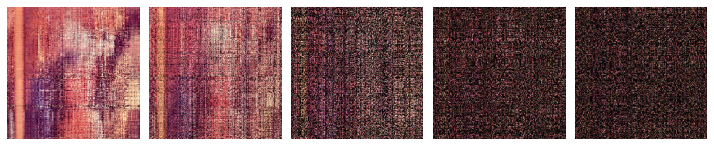

In [0]:
fig = plt.figure(figsize=(10, 10))
n_img = len(missing_rates)

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(cp.asnumpy(prediction))

fig.tight_layout(pad=1.0)

<h3>9D</h3>

In [0]:
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
predictions, rses, psnrs, best_ranks = run_TT_experiment(img, missing_rates, tensorize_img=True)

         Current function value: 0.022227
         Iterations: 10000
         Function evaluations: 15822
         Gradient evaluations: 15822
mr: 0.85
rank: 16
rse: 0.35384712671883317
psnr: 14.144280835759101
time: 1099.9515709877014
         Current function value: 0.018247
         Iterations: 10000
         Function evaluations: 15132
         Gradient evaluations: 15132
mr: 0.9
rank: 16
rse: 0.3352186332490358
psnr: 14.6140312835014
time: 1004.9023940563202
         Current function value: 0.013702
         Iterations: 10000
         Function evaluations: 15943
         Gradient evaluations: 15943
mr: 0.95
rank: 16
rse: 0.32839533766346807
psnr: 14.792654651010203
time: 1062.9234850406647
         Current function value: 0.110059
         Iterations: 10000
         Function evaluations: 15382
         Gradient evaluations: 15382
mr: 0.98
rank: 16
rse: 0.8580373946825579
psnr: 6.450469993807619
time: 1033.8518533706665
         Current function value: 0.041748
         Iterations:

In [0]:
print("best ranks")
print(best_ranks)
print("rse")
print(rses)
print("psnr")
print(psnrs)

best ranks
{'mr_0.85': 16, 'mr_0.9': 16, 'mr_0.95': 16, 'mr_0.98': 16, 'mr_0.99': 16}
rse
{'mr_0.85': 0.35384712671883317, 'mr_0.9': 0.3352186332490358, 'mr_0.95': 0.32839533766346807, 'mr_0.98': 0.8580373946825579, 'mr_0.99': 0.834705024516208}
psnr
{'mr_0.85': 14.144280835759101, 'mr_0.9': 14.6140312835014, 'mr_0.95': 14.792654651010203, 'mr_0.98': 6.450469993807619, 'mr_0.99': 6.689933749412136}


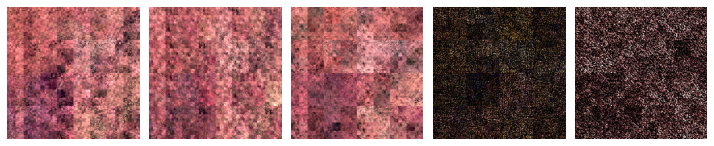

In [0]:
fig = plt.figure(figsize=(10, 10))
n_img = len(missing_rates)

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(cp.asnumpy(prediction))

fig.tight_layout(pad=1.0)